In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.datasets
import torchvision.transforms as T
from torchvision.utils import make_grid
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

## Load the Data

In [2]:
transform = T.Compose([T.Resize((800, 1200)), T.ToTensor()])

train_data = torchvision.datasets.FGVCAircraft(root='./../datasets', split='trainval', transform=transform, download=True)
test_data = torchvision.datasets.FGVCAircraft(root='./../datasets', split='test', transform=transform, download=True)

In [3]:
train_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=128,
                                          shuffle=True,
                                          num_workers=2)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=128,
                                          shuffle=True,
                                          num_workers=2)

In [4]:
image_tensor, label = train_data[3]

print("Dimension of single image:", image_tensor.shape)

Dimension of single image: torch.Size([3, 800, 1200])


## Split Images into Fixed-Size Patches

In [5]:
def split_patches(x, patch_size):
    N, C, H, W = x.shape 
    H_p, W_p = (H // patch_size), (W // patch_size)
    num_patches = H_p * W_p
    assert num_patches > 0, "Please determine proper patch size according to the dimension of images"
    
    patches = torch.reshape(x, (N, C, H_p, patch_size, W_p, patch_size))
    patches = patches.permute(0, 2, 4, 1, 3, 5)        # (N, H_p, W_p, C, P, P)
    patches = patches.flatten(1, 2)                    # (N, N_p, C, P, P)  where N_p = H_p*W_p

    return patches

In [ ]:
def patch_embeddings(patches, hidden_size):
    
    patches = patches.flatten(start_dim=2, end_dim=4)  # (N, N_p, C, P, P) --> (N, N_p, C*P*P)
    linear_projection = nn.Linear(patches.shape[-1], hidden_size)  # (C*P*P, h) where P: patch_size
    patch_embeddings = linear_projection(patches)
    
    return patch_embeddings # (N, N_p, h)

## Positional Embeddings

Positional embeddings can be generated in 2 ways: using sine and cosine functions or initializing learnable parameter

In [ ]:
def image_embeddings(patch_embed):
    
    N, N_p, hidden_size = patch_embed.shape
    pos_embedding = nn.Parameter(torch.randn(1, N_p + 1, hidden_size))
    class_tokens = nn.Parameter(torch.randn(1, 1, hidden_size)) # After the transformer blocks, we will use it for the classification.
    
    class_tokens = class_tokens.repeat(N, 1, 1) # class tokens will be the same for all images, so we repeat it.
    patch_embed = torch.cat((class_tokens, patch_embed), dim=1) # class tokens come the first. 
    patch_embed += pos_embedding
    
    return patch_embed

## Multi-Head Attention

In [ ]:
class Attention(nn.Module):
    def __init__(self, h, d):
        super(Attention, self).__init__()
        self.d = d
        
        self.query = nn.Linear(h, d, bias=False) # d: head dimension
        self.key = nn.Linear(h, d, bias=False)
        self.value = nn.Linear(h, d, bias=False)
        
    def forward(self, x):  # x: (N, N_p + 1, h)
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        
        attention_scores = torch.matmul(q, k.transpose(1, 2)) / pow(self.d, 0.5) # since k is 3D, we give dimensions to be transposed inside
        attention_probs = F.softmax(attention_scores, dim=-1)
        att_weights = torch.matmul(attention_probs, v)
        
        return att_weights

In [ ]:
class MultiHeadAttention(nn.Module):  
  
    def __init__(self, h, num_heads):  
        super().__init__()  
        
        # "To keep compute and number of parameters constant when changing num_heads, single head dimension is typically set to h/num_heads"
        single_head_dim = h // num_heads  
        concat_head_dim = num_heads * single_head_dim  
        
        self.heads = nn.ModuleList([Attention(h, single_head_dim) for _ in range(num_heads)])  # initialize each attention head
        self.linear = nn.Linear(concat_head_dim, h)  
  
    def forward(self, x):  
        att_list = [head(x) for head in self.heads]  # put each attention's output into the list
        output = torch.cat(att_list, dim=-1)  # concatenate them
  
        output = self.linear(output)  # project them to get the same dimension as that of the input
        return output

## Transformer Encoder

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, h, num_heads, prob):
        super(TransformerEncoder, self).__init__()
        
        self.norm1 = nn.LayerNorm(h)
        self.MHA = MultiHeadAttention(h, num_heads)
        self.norm2 = nn.LayerNorm(h)
        self.MLP = nn.Sequential(  
            nn.Linear(h, 2*h),  
            nn.Dropout(prob),  
            nn.GELU(),  
            nn.Linear(2*h, h),  
            nn.Dropout(prob)  
        ) 
        
    def forward(self, x):  # x: embedded patches
        output = x + self.MHA(self.norm1(x))
        output = output + self.MLP(self.norm2(output))
        
        return output                

# ViT Model

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, patch_size, hidden_size, prob, num_heads, num_encoders, num_classes):
        super(VisionTransformer, self).__init__()
        
        self.patch_size = patch_size
        self.h = hidden_size
        self.mha = MultiHeadAttention(hidden_size, num_heads)
        
        self.encoders = nn.ModuleList([TransformerEncoder(hidden_size, num_heads, prob) for _ in range(num_encoders)])
        self.classifier = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x): # x: images
        
        patches = split_patches(x, self.patch_size)
        patch_embed = patch_embeddings(patches, self.h)
        
        embeddings = image_embeddings(patch_embed)
        output = self.mha(embeddings)
        
        for encoder in self.encoders:
            output = encoder(output)
            
        logits = self.classifier(output[:,0,:]) # we get just the class token out of this
        
        return logits

## Hyperparameters

In [6]:
patch_size = 200
hidden_size = 1000
prob = 0.1
n_heads = 3
n_encoders = 2
n_classes = 100

## Model Training

In [ ]:
model = VisionTransformer(patch_size, hidden_size, prob, n_heads, n_encoders, n_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
num_epochs = 10

for epoch in range(num_epochs):
    model = model.train()
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        logits = model(images)
        loss = F.cross_entropy(logits, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f"Epoch: {epoch+1:03d}/{num_epochs:03d}"
              f" | Batch {batch_idx:03d}/{len(train_loader):03d}"
              f" | Train Loss: {loss:.2f}")
        
    # train_acc = compute_accuracy(model, train_loader)
    # print("Train Acc {train_acc*100:.2f}%")

## Model Evaluation

In [ ]:
with torch.no_grad():
    model = model.eval()
    correct = 0
    total_loss = 0.0
    total_examples = 0
    
    for images, labels in test_loader:
        logits = model(images)
        loss = F.cross_entropy(logits, labels)
        total_loss += loss.item()
        
    predictions = torch.argmax(logits, dim=1)
    average_loss = total_loss / len(test_loader)
    correct += torch.sum(labels == predictions)
    total_images += len(labels)
    
    print(f"Test loss: {average_loss:.2f}")
    print(f"Test accuracy: {correct / total_images * 100:.2f}%")

## Display one of images as the patched image

In [7]:
image_tensor = image_tensor.unsqueeze(dim=0)
patched_image = split_patches(image_tensor, patch_size).squeeze(dim=0)

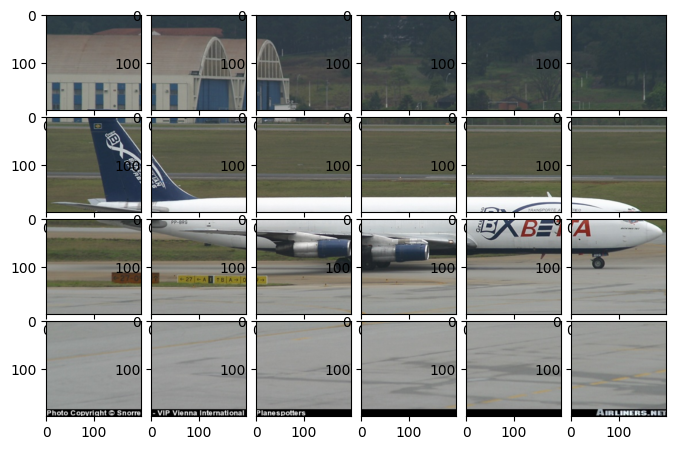

In [8]:
N, C, H, W = image_tensor.shape 
H_p, W_p = (H // patch_size), (W // patch_size)

transform2 = T.ToPILImage()
_, axs = plt.subplots(H_p, W_p, figsize=(8, 8))
axs = axs.flatten()
for img, ax in zip(patched_image, axs):
    img = transform2(img)
    ax.imshow(img)
plt.subplots_adjust(wspace=0.1, hspace=0, top=.62)

plt.show()